<a href="https://colab.research.google.com/github/Xixaus/Standard_add/blob/main/Standardni_pridavek_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metoda standardního přídavku


- Program slouží k výpočtu koncentrace vzorku pomocí metody standardního přídavku nebo standardního přídavku za konstantního objemu a vytvoření příslušného grafu
- Nejdříve se připojte k hostujícímu prostředí v pravé horní části (musíte být přihlášený ke Google účtu)
- Poté zadejte do první buňky hodnoty !podle návodu!, výpočet a graf vygenerujete spuštěním druhé buňky tlačítkem ▶ v levém horním rohu vedle nadpisu
- Při prvním spuštění se instaluje potřebná knihovna, tak to trvá déle, další výpočty jsou okamžité

- !!!Všechny objemy zadávejte ve stejných jednotkách, jednotlivá měření stejného roztoku oddělujte pomocí středníku (;), odezvy a objemy jednotlivých standardů pomocí lomítka (/)!!!




- V_unit: zadejte jednotku objemu, ve které budete zadávat všechny objemy (bez indexů)
- R_unit: zadejte jednotku měřené veličiny, která bude na y ose v grafu
- X_axys_name: zvolte v čem chcete mít X osu
- V_flask: zadejte objem odměrné baňky, v případě nezadání bude koncentrace vypočtena metodou přídavku standardu za zvýšení objemu
- V_sample: zadejte objem odpiptovaného vzorku, který je odpipetován do odměrné baňky nebo se k němu přidává standard
- R_sample: zadejte odezvy vzorku (např: 0.200; 0.204; 0.206)
- c_standard: zadejte koncentraci standardu
- c_unit: zadejte jednotku koncentrace standardu (bez indexů)
- V_standards: zadejte objemy přidaných standardů (např: 2.0 / 4.0 / 6.0 / 8.0 / 10.0)
- R_standard: zadejte odezvy odezvy standardů (např: 0.365; 0.360; 0.375 / 0.514; 0.51; 0.518)
- Pomocí volby Save_graph můžete graf uložit ve formátu .pdf, který se nachází ve složce soubory v levé části obrazovky pod ikonou 📁 s názvem graph.pdf. Dvojklikem soubor stáhnete

V případě že některá hodnota bude odlehlá od kalibrační závislosti, be červěně zbarvená v tabulce pro test odlehlých hodnot




In [ ]:
#@title Vstupní hodnoty { run: "auto", vertical-output: true }
V_unit = 'ul' #@param {type:"string"}
R_unit = "AU.s" #@param {type:"string"}
X_axys_name = "Zvysena koncentrace" #@param ["Zvysena koncentrace", "Pridany objem standardu"]
V_flask = 10000#@param {type:"number"}
V_sample =  1000#@param {type:"number"}
R_sample = "49,755; 53,591; 63,309" #@param {type:"string"}
c_standard =  100#@param {type:"number"}
c_unit = '%' #@param {type:"string"}
V_standards = "10"#@param {type:"string"}
R_standards = "290,722; 284,037; 294,586"#@param {type:"string"}
prediction_band = True #@param {type:"boolean"}
outlier_test = True #@param {type:"boolean"}

                            OLS Regression Results                            
Dep. Variable:          Odezva [AU.s]   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
No. Observations:                   6   F-statistic:                     2129.
Covariance Type:            nonrobust   Prob (F-statistic):           1.32e-06
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      55.5517      3.589     15.477      0.000      45.586      65.517
Zvýšená koncentrace (%)  2342.3000     50.759     46.145      0.000    2201.370    2483.230



,Vzorek
Koncetrace analytu [%],0.237
Směrodatná odchylka [%],0.019
Relativní směrodatná odchylka %,8.1
Interval spolehlivosti 95%,0.054


,Odezva [AU.s],Přidaný standard [ul],G
0,49.755,0.0,1.14
1,53.591,0.0,0.39
2,63.309,0.0,1.53
3,290.722,10.0,0.19
4,284.037,10.0,1.13
5,294.586,10.0,0.95


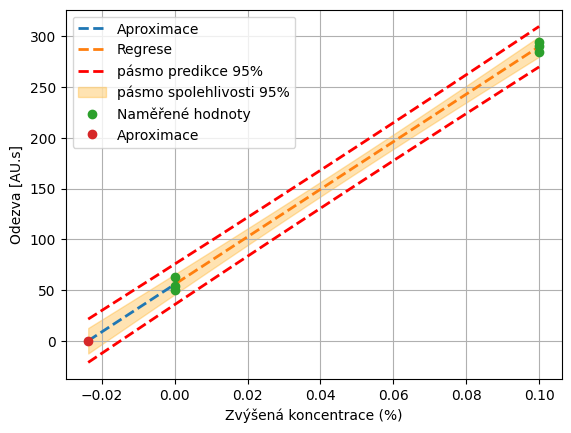

In [ ]:
#@title Graf s výsledkem

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

warnings.simplefilter('ignore', sm.tools.sm_exceptions.ValueWarning)
warnings.simplefilter('ignore', sm.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def data_extract(V_standards, R_sample, R_standards):
    str1 = ("0 / " + V_standards).replace(",", ".")
    str2 = (R_sample + " / " + R_standards).replace(",", ".")

    list1, list2, data = str1.split('/'), str2.split('/'), []

    for i in range(len(list2)):
        for num in list2[i].split(';'):
            data.append([float(num), float(list1[i])])

    col = [f"Odezva [{R_unit}]", f"Přidaný standard [{V_unit}]"]

    return(pd.DataFrame(data, columns=col))

def std_reg(df, model):
    if model.df_resid == 0:
      return (0)

    x, y = df.iloc[:,1].values, df.iloc[:,0].values
    intercept = model.params[1]
    sxx = np.var(x, ddof=0) * len(x) #čitatel kovarience xx
    Sy = np.sqrt(model.scale) #Směrodatná odchylka regrese

    Sx = (Sy/abs(intercept)) * np.sqrt((1/len(x))+(y.mean()**2/((intercept**2)*sxx))) #směrodatná odchylka výsledku
    return (Sx)

def evaluation(model, df, sample,c_unit):
    Sx = std_reg(df, model)

    if V_flask == None: #výpočet koncetrace v případě volby metody standardního přídavku
        if X_axys_name == "Zvysena koncentrace":
          final_sample = sample #výpočet koncentrace vzorku
          final_sample_st_dev = Sx
          sample_name = "Zvýšená koncentrace roztoku vzorku"
        else:
          final_sample = sample * c_standard / V_sample #přepočtení objemu standardu na koncentraci
          final_sample_st_dev = Sx * c_standard / V_sample
          sample_name = "Objem standardu ve vzorku"

    else: #výpočet koncetrace v případě volby metody standardního přídavku za konstantního objemu
        if X_axys_name == "Zvysena koncentrace":
          final_sample = sample * V_flask / V_sample #výpočet koncentrace vzorku
          final_sample_st_dev = Sx * V_flask / V_sample
          sample_name = "Koncetrace roztoku vzorku"
        else:
          final_sample = sample * c_standard / V_sample #přepočtení objemu standardu na koncentraci
          final_sample_st_dev = Sx * c_standard / V_sample
          sample_name = "Objem standardu ve vzorku"

    if model.df_resid == 0:
        final_sample_con_int = 0
    else:
        final_sample_con_int = final_sample_st_dev * scipy.stats.t.ppf(q=0.975,df=model.df_resid) #výpočet intervalu spolehlivosti 0,05

    Rel_std = final_sample_st_dev/final_sample * 100

    result = pd.DataFrame(index=[f'Koncetrace analytu [{c_unit}]', f'Směrodatná odchylka [{c_unit}]', "Relativní směrodatná odchylka %", "Interval spolehlivosti 95%"])
    sig_num = str(float('%.2g' % final_sample_st_dev))[::-1].find('.')

    result["Vzorek"] = [round(final_sample, sig_num), round(final_sample_st_dev, sig_num), round(Rel_std, 1), round(final_sample_con_int, sig_num)]
    result.loc["Relativní směrodatná odchylka %"] = result.loc["Relativní směrodatná odchylka %"].apply(lambda x: format(x, '.1f'))

    return (result)

def outlier_value(model):
  df = data_extract(V_standards, R_sample, R_standards)
  residuals = model.resid
  Sxy = np.sqrt(model.scale)
  df["G"] = abs(residuals) / Sxy * np.sqrt(model.nobs/model.df_resid)

  t_crit = scipy.stats.t.ppf(1 - 0.1/(2*model.nobs), df=model.nobs-2)
  G_crit = ((model.nobs-1) * t_crit) / np.sqrt(model.nobs * (model.nobs-2 + t_crit**2))

  def highlight_rows(row):
      if row['G'] > G_crit:
          return ['background-color: red']*len(row)
      else:
          return ['']*len(row)

  def count_decimals(x):
    if isinstance(x, float):
        return len(str(x).split('.')[1])
    else:
        return 0

  df_0_decimals, df_1_decimals = df[df.columns[0]].apply(count_decimals).max(), df[df.columns[1]].apply(count_decimals).max()

  df = df.style.apply(highlight_rows, axis=1).format({df.columns[0]: "{:." + str(df_0_decimals) + "f}",
                                                      df.columns[1]: "{:." + str(df_1_decimals) + "f}",
                                                      "G": "{:.2f}"}
                                                     ).set_caption(f'<h2 style="font-weight: bold;">G crit 95% = {G_crit:.2f}</h2>')
  return (df)

def intervals(model, df, sample):
    x = df.iloc[:,1]
    y = df.iloc[:,0]
    t = scipy.stats.t.ppf(0.975, model.df_resid)

    x_line = np.linspace(-sample, np.max(x), 200)
    y_line = model.predict(sm.add_constant(x_line))

    ci = t * np.sqrt(model.scale) * (1/model.nobs + (x_line - x.mean())**2 / np.sum((x - x.mean())**2))**.5
    pi = t * np.sqrt(model.scale) * (1 + 1/model.nobs + (x_line - x.mean())**2 / np.sum((x - x.mean())**2))**.5

    return(pd.DataFrame([x_line, y_line,  y_line+pi, y_line-pi, y_line+ci, y_line-ci], index = ["x","y", "upp_ci", "under_ci", "upp_pi", "under_pi"]).T)

df = data_extract(V_standards, R_sample, R_standards)

if V_flask == None: #Volba konstatního objemu nebo přídavku
  graph_name = "Standardní přídavek"
  if X_axys_name == "Zvysena koncentrace": #zjištění volby zobrazení
    x_name = f"Zvýšená koncentrace ({c_unit})" #vytvoření legendy
    df.iloc[:,1] = (df.iloc[:,1] * c_standard)/ V_sample
  else:
    x_name = f"Přidaný objem standardu ({V_unit})"

else:
  graph_name = "Standardní přídavek za konstantního objemu"
  if X_axys_name == "Zvysena koncentrace": #zjištění volby zobrazení
    x_name = f"Zvýšená koncentrace ({c_unit})" #vytvoření legendy
    df.iloc[:,1] = df.iloc[:,1] * c_standard / V_flask #přepočtení objemů standardu na koncentraci v odměrné baňce
  else:
    x_name = f"Přidaný objem standardu [{V_unit}]"

df = df.rename(columns={f"Přidaný standard [{V_unit}]": x_name})

model = sm.OLS(df.iloc[:,0], sm.add_constant(df.iloc[:,1])).fit()
print(model.summary(slim = True).tables[0])
print('\n'.join(str(model.summary().tables[1]).split('\n')[1:]))
print()

sample = model.params[0] / model.params[1] #vypočtení množství standardu/koncentrace vzorku
result = evaluation(model, df, sample, c_unit)
intervals = intervals(model, df, sample)
mask_aproximation, mask_regresion = intervals["x"] < 0, intervals["x"] > 0

display(result)

if outlier_test == True:
  display(outlier_value(model))

plt.plot(intervals.loc[mask_aproximation, "x"], intervals.loc[mask_aproximation, "y"], '--', lw=2, label="Aproximace")
plt.plot(intervals.loc[mask_regresion, "x"], intervals.loc[mask_regresion, "y"], '--', lw=2, label="Regrese")

if prediction_band == True:
    plt.plot(intervals["x"], intervals["under_ci"], 'r--', lw=2)
    plt.plot(intervals["x"], intervals["upp_ci"], 'r--', lw=2, label="pásmo predikce 95%")
    plt.fill_between(intervals["x"], intervals["under_pi"], intervals["upp_pi"] , color='orange', alpha=0.3, label="pásmo spolehlivosti 95%")

plt.plot(df.iloc[:,1].values, df.iloc[:,0].values, 'o', label="Naměřené hodnoty")
plt.plot(-sample, 0, 'o', label="Aproximace")

plt.legend()
plt.grid()
plt.xlabel(x_name)
plt.ylabel(f"Odezva [{R_unit}]")

plt.savefig("graph.svg", bbox_inches="tight")
plt.show()

In [ ]:
def data_extract(V_standards, R_sample, R_standards):
    str1 = ("0 / " + V_standards).replace(",", ".")
    str2 = (R_sample + " / " + R_standards).replace(",", ".")

    list1, list2, data = str1.split('/'), str2.split('/'), []

    for i in range(len(list2)):
        for num in list2[i].split(';'):
            data.append([float(list1[i]), float(num)])

    col = ["Přidaný standard", "Odezva"]

    return(pd.DataFrame(data, columns=col))

data_extract(V_standards, R_sample, R_standards)

,Přidaný standard,Odezva
0,0.0,49.755
1,0.0,53.591
2,0.0,53.309
3,10.0,290.722
4,10.0,284.037
5,10.0,284.586


In [ ]:
#@title Graf s výsledkem
import os
import numpy as np
import pandas as pd
import math
import scipy.stats
from scipy.optimize import curve_fit
from scipy.stats import t
import matplotlib.pyplot as plt
from IPython.display import clear_output

try:
    import uncertainties.unumpy as unp
    import uncertainties as unc
except:
    !pip install uncertainties
    clear_output(wait=True)
    import uncertainties.unumpy as unp
    import uncertainties as unc

#import knihoven

def data_extract(V_standards, R_standards, R_sample):
    R_st3  = [] #vytvoření prázdných listů

    R_st1 = (R_standards.replace(",", ".")).split("/")
    V_st1 = (V_standards.replace(",", ".")).split("/")
    R_sa1 = (R_sample.replace(",", ".")).split(";") #separace vstupních stringů na seznamy podle dělécího znaménka a převedení , na .

    V_st2 = list(np.zeros((len(R_sa1)), dtype='uint8'))

    R_st2 = [R_st1[i].split(";") for i in range(len(R_st1))] #rozseparování stringů odezev na seznamy

    for i in range(len(R_st2)): #znásobení objemů standardů podle počtu odezev a přidání k 0 hodnotám
      for ii in range(len(R_st2[i])):
        V_st2.append(V_st1[i])

    R_st3 = [item for sublist in R_st2 for item in sublist] #převedení vnořených seznamů do jednoho seznamu

    X = [float(i) for i in (V_st2)] #převedení objemů na float
    y = [float(i) for i in (R_sa1 + R_st3)] # spojení odezev vzorku a standardů a převedení na float

    index = ["Vzorek"] + [f"{i+1}. přídavek" for i in range(len(V_st1))]
    data = [R_sa1] + R_st2

    df = pd.DataFrame(data = data, index = index).astype(float)
    df.columns = range(1, len(df.columns)+1)

    return (X, y, df)

X, y, df = data_extract(V_standards, R_standards, R_sample) #extrakce dat ze vstupů

if V_flask == None: #Volba konstatního objemu nebo přídavku
  graph_name = "Standardní přídavek"
  if X_axys_name == "Zvysena koncentrace": #zjištění volby zobrazení
    x = [(X[i]*c_standard)/(V_sample + X[i]) for i in range(len(X))]
    x_name = f"Zvýšená koncentrace ({c_unit})" #vytvoření legendy
  else:
    x = X
    x_name = f"Přidaný objem standardu ({V_unit})"

else:
  graph_name = "Standardní přídavek za konstantního objemu"
  if X_axys_name == "Zvysena koncentrace": #zjištění volby zobrazení
    x = [X[i]*(c_standard/V_flask) for i in range(len(X))] #přepočtení objemů standardu na koncentraci v odměrné baňce
    x_name = f"Zvýšená koncentrace ({c_unit})" #vytvoření legendy
  else:
    x = X
    x_name = f"Přidaný objem standardu ({V_unit})"

def f(x, a, b):
    return a * x + b

popt, pcov = curve_fit(f, x, y)
poly1d_fn = np.poly1d(popt) #převedení na rovnici regrese
R2 = (np.corrcoef(x, y)[0,1])**2 #výpočet korelačního koeficientu
a,b = unc.correlated_values(popt, pcov)

def std_reg(R2, x, y): #Funkce pro výpočet směrodatné odchylky
  if R2 == 1: # v případě dokonalé korelace, zastavení výpočtu odchylky
    Sx = 0
  else:
    x_ave = sum(x)/len(x)
    y_ave = sum(y)/len(y) #výpočet průměrů

    S_rezid = 0
    for i in range(len(x)):
      S_rezid += (y[i]-popt[0]*x[i]-popt[1])**2 #Součet druhých mocnin reziduí

    sx = 0
    for i in range(len(x)):
      sx += (x[i]-x_ave)**2 #čitatel kovarience xx

    Sy = math.sqrt(S_rezid/(len(x)-2)) #Směrodatná odchylka regrese
    Sx = (Sy/abs(popt[0]))*math.sqrt((1/len(x))+(y_ave**2/((popt[0]**2)*sx))) #směrodatná odchylka výsledku

    return(Sx)

if std_deviation == True:
  Sx = std_reg(R2, x, y) #Výpočet smerodatné odchylky

else:
  Sx = 0

sample = popt[1]/popt[0] #vypočtení množství standardu/koncentrace vzorku

if V_flask == None: #výpočet koncetrace v případě volby metody standardního přídavku
  if X_axys_name == "Zvysena koncentrace":
    final_sample = sample #výpočet koncentrace vzorku
    final_sample_st_dev = Sx
    sample_name = "Zvýšená koncentrace roztoku vzorku"
  else:
    final_sample = sample * c_standard / V_sample #přepočtení objemu standardu na koncentraci
    final_sample_st_dev = Sx * c_standard / V_sample
    sample_name = "Objem standardu ve vzorku"

else: #výpočet koncetrace v případě volby metody standardního přídavku za konstantního objemu
  if X_axys_name == "Zvysena koncentrace":
    final_sample = sample * V_flask / V_sample #výpočet koncentrace vzorku
    final_sample_st_dev = Sx * V_flask / V_sample
    sample_name = "Koncetrace roztoku vzorku"
  else:
    final_sample = sample * c_standard / V_sample #přepočtení objemu standardu na koncentraci
    final_sample_st_dev = Sx * c_standard / V_sample
    sample_name = "Objem standardu ve vzorku"

if R2 != 1:
  final_sample_con_int = final_sample_st_dev * scipy.stats.t.ppf(q=0.975,df=(len(x)-2)) #výpočet intervalu spolehlivosti 0,05

x.insert(0, -sample) #přidání koncentrace/objemu standardu ve vzorku
y.insert(0, 0) #přidaní nulové hodnoty na začátek seznamu

def predband(x, xd, yd, p, func, conf=0.95): #funkce pro výpočet bodů preddikčního pásma
    alpha = 1.0 - conf    # significance
    N = (xd.size) - 2      # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = scipy.stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

px = np.linspace(x[0]*1.2, x[-1]*1.2, 100) #Vygenerování bodů pro znázornění pásem
py = a*px+b
nom = unp.nominal_values(py)
std = unp.std_devs(py)

plt.rcParams["figure.figsize"] = (19,9)
plt.grid() #nastavení parametrů grafu
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel(x_name)
plt.ylabel(R_unit)
plt.title(graph_name)

plt.scatter(x[1:], y[1:], s = 100, marker = "x", c = "red", label="Naměřené hodnoty") #vložení a nastavení hodnot v grafu
plt.scatter(x[0], y[0], s = 100, marker="o", c = "blue", label= sample_name)
plt.plot(x[1:], poly1d_fn(x[1:]), '--', label="Lineární regrese")
plt.plot(x[:2], poly1d_fn(x[:2]), ls = ':', label="Aproximace")

#plt.plot(px, nom - tinv(0.05, len(x)-3) * std, c='orange', label='95% Pásmo spolehlivosti')
#plt.plot(px, nom + tinv(0.05, len(x)-3) * std, c='orange')

if confidence_interval == True:
  tinv = lambda p, df: abs(t.ppf(p/2, df))
  plt.fill_between(px, nom - tinv(0.05, len(x)-3) * std, nom + tinv(0.05, len(x)-3) * std, color ='orange', alpha=.5, linewidth=0, label = "Pásmo spolehlivosti")

if prediction_band == True:
  lpb, upb = predband(px, np.array(x), np.array(y), popt, f, conf=0.95) #vygenerování bodů predikčního pásma
  tinv = lambda p, df: abs(t.ppf(p/2, df))
  plt.plot(px, lpb, '--', color='red', label='95% Pásmo predikce')
  plt.plot(px, upb, '--', c='red')

plt.legend(loc='best')

def Dean_Dixon(df):
  q95 = {3: 0.941, 4: 0.765, 5: 0.642, 6: 0.560, 7: 0.507, 8: 0.468, 9: 0.437, 10: 0.412}

  df = df.assign(Počet=df.apply(lambda x: x.count(), axis=1))
  df = df.assign(Qkrit95=df.apply(lambda x: q95.get(x['Počet'], np.nan), axis=1))
  df = df.assign(Qmin = df.iloc[:,:-2].apply(lambda x: ((np.partition(x.dropna(), 1)[1] - np.partition(x.dropna(), 1)[0])/ (x.max()-x.min())), axis=1))
  df = df.assign(Qmax = df.iloc[:,:-3].apply(lambda x: ((np.partition(x.dropna(), -1)[-1] - np.partition(x.dropna(), -1)[-2])/ (x.max()-x.min())), axis=1))
  df["Qmin"] = df["Qmin"].round(3)
  df["Qmax"] = df["Qmax"].round(3)
  df.fillna('', inplace=True)

  return(df)

if DeanDixon_test is True:
  print("Dean-Dixonův test zadaných hodnot")
  print(Dean_Dixon(df))

print()

print(f"y = {popt[0]:.3e}x + {popt[1]:.3e}")
print(f"R\u00B2: {R2:.4f}")
print()
print(f"Koncentrace analytu: {final_sample:.3} {c_unit}")

if std_deviation == True: # v případě dokonalé korelace, nevypsání odchylky a intervalu spolehlivosti
  print(f"Směrodatná odchylka: {final_sample_st_dev:.2} {c_unit}")
  print(f"Interval spolehlivosti: {final_sample_con_int:.2} {c_unit}")

if Save_graph is False:
  plt.show()

else:
  plt.savefig("graph.jpeg", bbox_inches="tight")

NameError: ignored